In [1]:
import xarray as xr

ds = xr.open_dataset("data/ERA5_LowRes_Monthly_evap.nc")
print(ds)

var = list(ds.data_vars)[0]
print(var)
print(ds[var])

<xarray.Dataset> Size: 888MB
Dimensions:    (time: 480, latitude: 241, longitude: 480)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2018-12-01
  * latitude   (latitude) float32 964B 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 2kB -179.6 -178.9 -178.1 ... 178.9 179.6
Data variables:
    e          (time, latitude, longitude) float64 444MB ...
    pev        (time, latitude, longitude) float64 444MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-08 21:23:09 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...
e
<xarray.DataArray 'e' (time: 480, latitude: 241, longitude: 480)> Size: 444MB
[55526400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2018-12-01
  * latitude   (latitude) float32 964B 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 2kB -179.6 -178.9 -178.1 ... 178.9 179.6
Attributes:
    units:          m of water equival

In [4]:
ds[var].mean().item()


-0.0021522626127847954

In [9]:
import numpy as np
#help(np.std) # standard deviation
ds[var].std().item()

0.0020040601194466694

In [12]:
ds.time.values[:5]

array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', '1979-04-01T00:00:00.000000000',
       '1979-05-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
ds.time.values[-5:]

array(['2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
ds[list(ds.data_vars)[1]]

<xarray.DataArray 'pev' (time: 480, latitude: 241, longitude: 480)> Size: 444MB
[55526400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2018-12-01
  * latitude   (latitude) float32 964B 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float32 2kB -179.6 -178.9 -178.1 ... 178.9 179.6
Attributes:
    units:      m
    long_name:  Potential evaporation

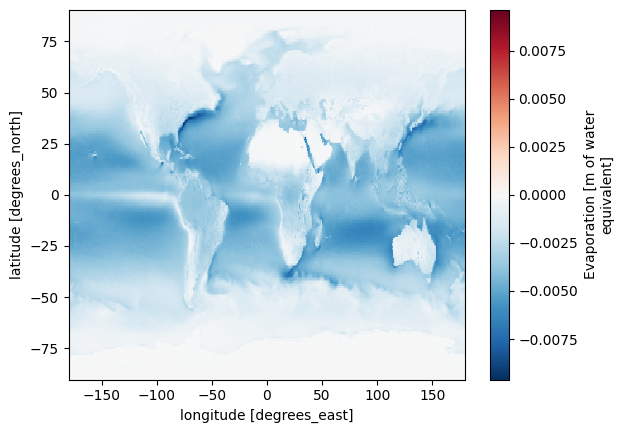

In [28]:
pev = ds["e"]
pev.mean(dim="time").plot()

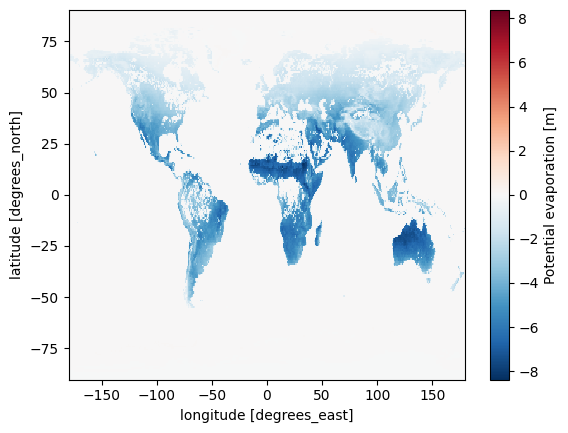

In [29]:
ds["e_mm_day"] = ds["e"] * 1000
ds["pev_mm_day"] = ds["pev"] * 1000
pev_mm_day = ds["pev_mm_day"]
pev_mm_day.mean(dim="time").plot()

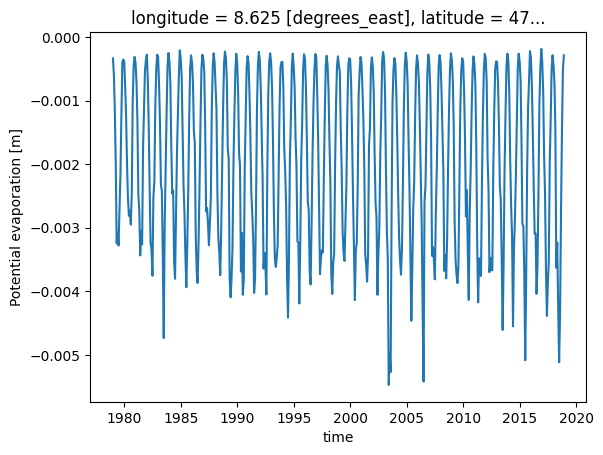

In [32]:
lat0 = 47.37
lon0 = 8.55

point = ds["pev"].sel(
    latitude = lat0, longitude = lon0,
    method = "nearest"
)
point.plot()

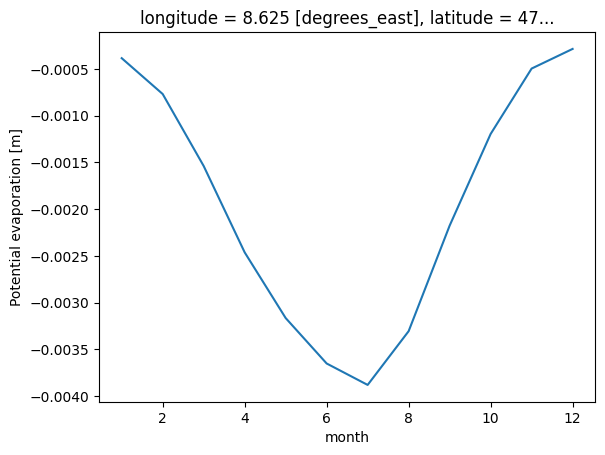

In [33]:
# Remove the seasonal oscillations
climatology = point.groupby("time.month").mean("time")
climatology.plot(label="climatology")

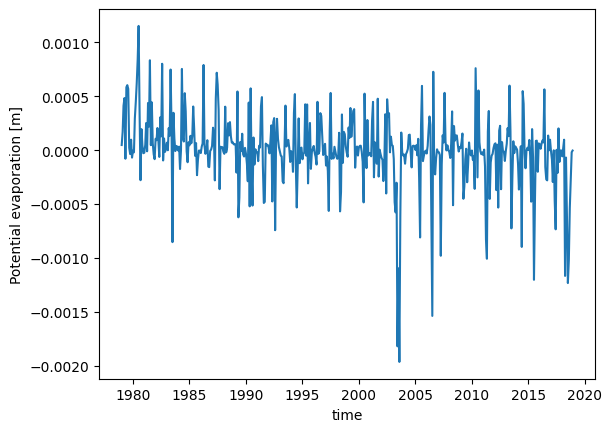

In [34]:
# Subtract from the data
anomalies = point.groupby("time.month") - climatology
anomalies.plot(label="anomalies")

In [45]:
# inspect the autocorrelation
import pandas as pd

x = anomalies.values
x = x[np.isfinite(x)]

s = pd.Series(x)
for i in range(1, 10):
    print(f"Autocorrelation with lag: {i} is {s.autocorr(lag=i):4.3f}")


Autocorrelation with lag: 1 is 0.262
Autocorrelation with lag: 2 is 0.119
Autocorrelation with lag: 3 is 0.177
Autocorrelation with lag: 4 is 0.084
Autocorrelation with lag: 5 is 0.059
Autocorrelation with lag: 6 is 0.012
Autocorrelation with lag: 7 is 0.010
Autocorrelation with lag: 8 is 0.025
Autocorrelation with lag: 9 is 0.059


Help on function stem in module matplotlib.pyplot:

stem(
    *args: ArrayLike | str,
    linefmt: str | None = None,
    markerfmt: str | None = None,
    basefmt: str | None = None,
    bottom: float = 0,
    label: str | None = None,
    orientation: Literal['vertical', 'horizontal'] = 'vertical',
    data=None
) -> StemContainer
    Create a stem plot.

    A stem plot draws lines perpendicular to a baseline at each location
    *locs* from the baseline to *heads*, and places a marker there. For
    vertical stem plots (the default), the *locs* are *x* positions, and
    the *heads* are *y* values. For horizontal stem plots, the *locs* are
    *y* positions, and the *heads* are *x* values.

    Call signature::

      stem([locs,] heads, linefmt=None, markerfmt=None, basefmt=None)

    The *locs*-positions are optional. *linefmt* may be provided as
    positional, but all other formats must be provided as keyword
    arguments.

    Parameters
    ----------
    locs : array-like, 

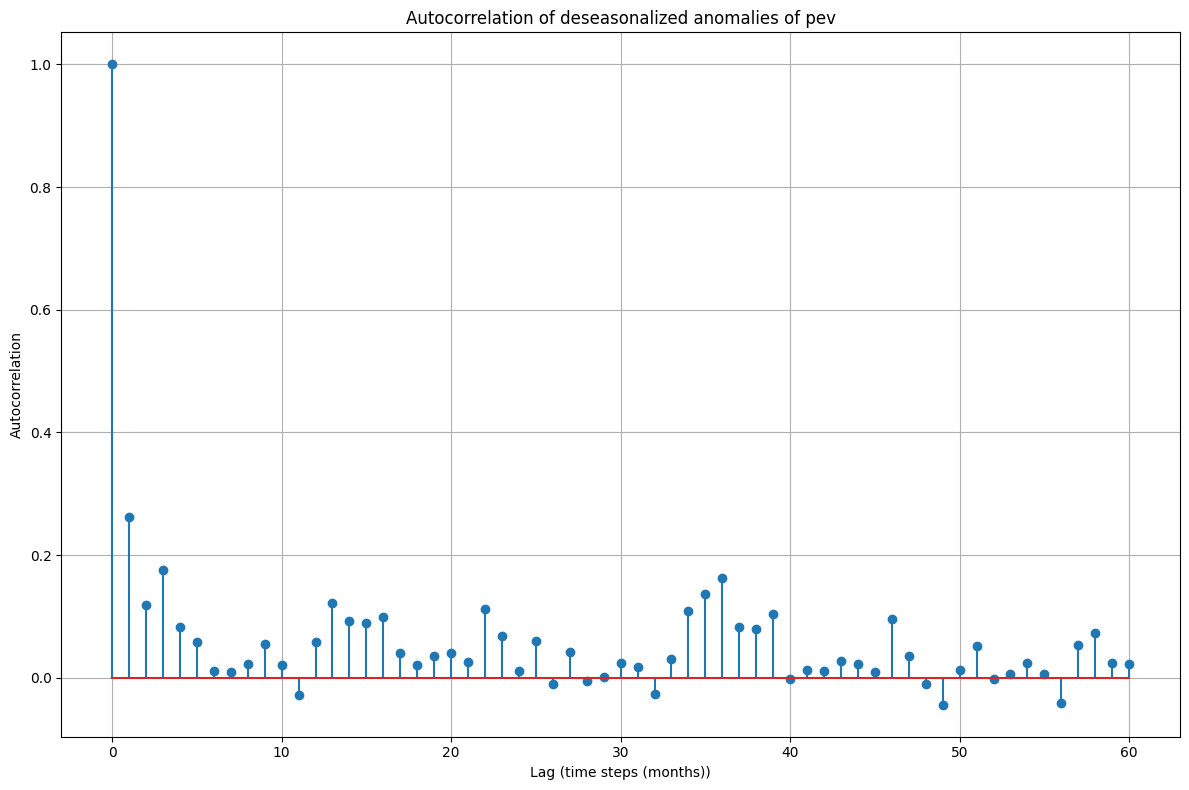

In [48]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

x = anomalies.values
x = x[np.isfinite(x)]

acf_vals = acf(x,nlags=60, fft=True)

plt.figure(figsize=(12,8))
print(help(plt.stem))
plt.stem(range(len(acf_vals)), acf_vals)
plt.xlabel("Lag (time steps (months))")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of deseasonalized anomalies of pev")
plt.grid(True)
plt.tight_layout()
plt.show()
